In [2]:
import ee
import geemap
import pandas as pd
from matplotlib import pyplot


#ee.Authenticate()  # Only needed for the first time
ee.Initialize()
Map= geemap.Map()

In [3]:
lake = ee.FeatureCollection('projects/ee-mazard/assets/adk-samplelakes') \
    .filter(ee.Filter.eq('GNIS_Name', 'Big Moose Lake'))



In [4]:
station = ee.Geometry.Point(-74.85423940003443,43.81880036802749)
#station = ee.Geometry.Point(-74.860826362721,43.82503425692791)

Map.addLayer(station)
Map.centerObject(station, 16)
Map

Map(center=[43.81880036802749, -74.85423940003443], controls=(WidgetControl(options=['position', 'transparent_…

In [5]:
LC5_BANDS = ['SR_B1',   'SR_B2',    'SR_B3',  'SR_B4',  'SR_B5',    'SR_B7',    'ST_B6','QA_PIXEL']; #Llandsat 5
LC8_BANDS = ['SR_B2','SR_B3','SR_B4',  'SR_B5','SR_B6','SR_B7','ST_B10','QA_PIXEL']; #Landsat 8
STD_NAMES = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'temp','QA'];


In [6]:
def cdom(img):
    cdo = img.expression("(20.3 - 10. * (b2 / b3) - 2.4 * (b3 / b4))", {
        'b1' : img.select('blue'),
        'b2' : img.select('green'),
        'b3' : img.select('red'),
        'b4' : img.select('nir')
    }).rename("CO")
    
    bad2 = cdo.where((cdo.gte(0)),1).rename("bad2");
    co= cdo.multiply(bad2).rename("CO");
    mask = co.neq(0);

    return img.addBands([co]).clip(lake).updateMask(mask)
#     return ee.Image(img
#       .addBands(co)
#       .clip(lake)
#       .updateMask(mask)
#     )   
#         #return img.addBands([co])


In [7]:
def maskL457sr(image):
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
    saturationMask = image.select('QA_RADSAT').eq(0)
    qa = image.select('QA_PIXEL')
    cloud = qa.bitwiseAnd(1 << 5).Or(qa.bitwiseAnd(1 << 7)).Or(qa.bitwiseAnd(1 << 3))
    masked = image.updateMask(cloud.Not())
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBand = image.select('ST_B6').multiply(0.00341802).add(-124.15)
    return image.addBands(opticalBands, None, True).addBands(thermalBand, None, True).updateMask(masked).updateMask(qaMask).updateMask(saturationMask)


l5 = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2') \
   .filter(ee.Filter.calendarRange(5, 11, 'month')) \
   .filterBounds(station) \
   .filter(ee.Filter.lt('CLOUD_COVER', 25)) \
   .map(maskL457sr)\
   .select(LC5_BANDS, STD_NAMES)\
   .map(cdom)\
   

#l5 = l5


In [8]:
def maskL8sr(image):
    # Bit 0 - Fill
    # Bit 1 - Dilated Cloud
    # Bit 2 - Cirrus
    # Bit 3 - Cloud
    # Bit 4 - Cloud Shadow
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
    saturationMask = image.select('QA_RADSAT').eq(0)

    # Apply the scaling factors to the appropriate bands.
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBands = image.select('ST_B.*').multiply(0.00341802).add(-124.15)

    # Replace the original bands with the scaled ones and apply the masks.
    return image.addBands(opticalBands, None, True) \
        .addBands(thermalBands, None, True) \
        .updateMask(qaMask) \
        .updateMask(saturationMask)

l8 =ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(5, 11, 'month')) \
    .filterBounds(station) \
    .filter(ee.Filter.lt('CLOUD_COVER', 25)) \
    .map(maskL8sr) \
    .select(LC8_BANDS, STD_NAMES)\
    .map(cdom) \

#l8 = l8


#merge landsat 5 and landsat 8
lall = ee.ImageCollection(l5.merge(l8));




In [9]:
print(lall.size().getInfo())


437


In [10]:
# image_list = lall.toList(15)
# date= lall.get()

In [11]:
def reflectance(img):
    reflectance_values = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=station, scale=30).select(STD_NAMES)
    return img.set('date', img.date().format()).set('reflectance',reflectance_values)

In [12]:
map_reflectance = lall.map(reflectance)


In [14]:
list_relfectance = map_reflectance.reduceColumns(ee.Reducer.toList(2), ['date','reflectance']).values().get(0)



In [15]:
df_reflectance = pd.DataFrame(list_relfectance.getInfo(), columns=['date','reflectance'])
pd.set_option('display.max_rows', None)
df_reflectance['date'] = pd.to_datetime(df_reflectance['date'])
df_reflectance['date'] = df_reflectance['date'].dt.date


df_reflectance['reflectance'] = df_reflectance['reflectance'].apply(lambda x: {k: v for k, v in x.items() if v is not None})



#df_reflectance

In [16]:
import pandas as pd

# Create empty lists to store the data
data = []

# Extract the bands, reflectance values, and dates where available
for index, row in df_reflectance.iterrows():
    date = row['date']
    reflectance = row['reflectance']
    
    if reflectance:
        for band in STD_NAMES:
            value = reflectance.get(band)
            data.append({'Band': band, 'Reflectance': value, 'Date': date})

# Create a dataframe from the data
df_data = pd.DataFrame(data)

# Display the dataframe
print(df_data)



       Band   Reflectance        Date
0      blue      0.107532  1984-07-03
1     green      0.109650  1984-07-03
2       red      0.093122  1984-07-03
3       nir      0.160718  1984-07-03
4     swir1      0.048710  1984-07-03
5     swir2      0.033777  1984-07-03
6      temp     16.385310  1984-07-03
7        QA   5440.000000  1984-07-03
8      blue      0.026847  1988-06-12
9     green      0.027700  1988-06-12
10      red      0.016067  1988-06-12
11      nir      0.056355  1988-06-12
12    swir1      0.014555  1988-06-12
13    swir2      0.007433  1988-06-12
14     temp     18.378016  1988-06-12
15       QA   5440.000000  1988-06-12
16     blue      0.027425  1988-07-30
17    green      0.035015  1988-07-30
18      red      0.014885  1988-07-30
19      nir      0.071342  1988-07-30
20    swir1      0.016288  1988-07-30
21    swir2      0.009742  1988-07-30
22     temp     23.819504  1988-07-30
23       QA   5440.000000  1988-07-30
24     blue      0.036252  1989-08-18
25    green 

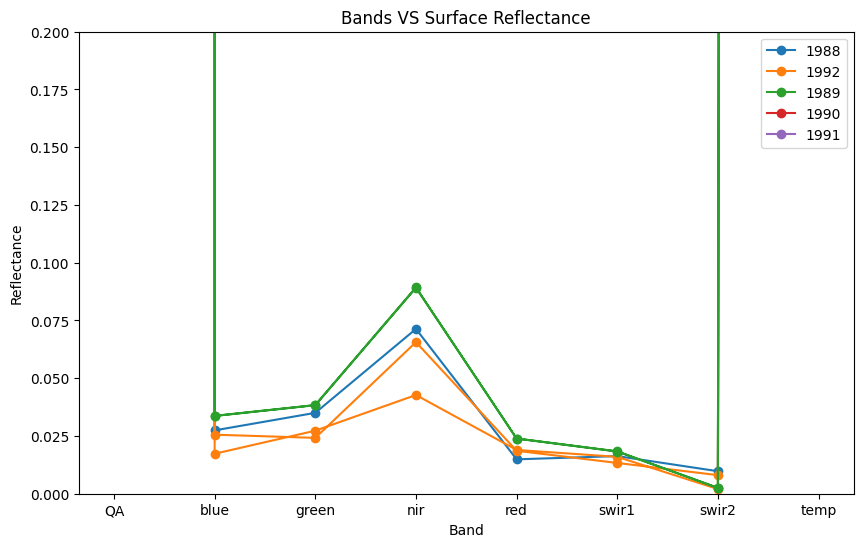

In [21]:
import matplotlib.pyplot as plt

data_by_year ={}

for index, row in df_reflectance.iterrows():
    date= row['date']
    reflectace=row['reflectance']
    
    if 1988 <=date.year <=1995 and date.month==7:
        year=date.year
        
        if year not in data_by_year:
            data_by_year[year]={'band':[], 'reflectance':[]}
            
        for band, value in reflectace.items():
            data_by_year[year]['band'].append(band)
            data_by_year[year]['reflectance'].append(value)
            
plt.figure(figsize=(10,6))

for year, data in data_by_year.items():
    plt.plot(data['band'], data['reflectance'], marker='o', label=year)
    
plt.xlabel('Band')
plt.ylabel('Reflectance')
plt.ylim(0,0.2)
plt.title('Bands VS Surface Reflectance')
plt.legend()
plt.show()